<a href="https://colab.research.google.com/github/halen48/Halftone-Enhance/blob/main/Halftone_Enhance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Halftone-Net // Halftone-EDSR <br>
GitHub Repository: https://github.com/halen48/Halftone-Enhance

In [ ]:
#@title Choosing the model
target_model = "Halftone-Net - Comics Halftone" #@param ["Halftone-EDSR - Syntethic Halftone", "Halftone-EDSR - Comics Halftone", "Halftone-Net - Comics Halftone"]

if('EDSR' in target_model):
  model_name = 'halftone_edsr'
else:
  model_name = 'halftone_net'

load_pre_trained_model = "True" #@param ['True', 'False']
if('Comics' in target_model):
  weights_name = f"{model_name}_db.h5"
else:
  weights_name = f"{model_name}_da.h5"

output_path = "/content/" #@param

load_pre_trained_model = bool(load_pre_trained_model)
mode = 'CMYK'
input_zoom = 0.5
output_zoom = 1

In [ ]:
#@title Dependencies
import os
from PIL import ImageOps, Image
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import numpy as np
from tensorflow import keras
from IPython.display import clear_output
!pip install ipyplot
import ipyplot
clear_output(wait=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00

        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


GPU VRAM Usage

In [ ]:
RAM_GBs = 15 #@param
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())
# Ref: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=RAM_GBs*1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print('>',e)

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [ ]:
#@title Training paramters
if(not load_pre_trained_model):

  batch_size = 2#@param
  epochs = 100#@param
  image_shape = (256,256)

  base_dir = 'PATH_TO_YOUR_DATASET' #@param
  random.seed(408)

  print(">images: %d"%len(os.listdir(base_dir+'/original/')))

  from tensorflow.python.tools import module_util
  #@title Dataset training parameters
  train_size = 0.7 #@param
  validation_split = 2/3 #@param
  k_fold = 5 #@param
  example_folds = [{'train':[],'test':[]} for i in range(k_fold)]

  example_images = os.listdir(base_dir+'/original/')

  random.shuffle(example_images)
  example_images = example_images[:900]

  size_fold = int(len(example_images)*train_size)


  print(size_fold)
  for fold in range(k_fold):
    example_folds[fold]['train'] += [base_dir+'/%s/'+v+'.npy' for v in example_images[:size_fold]]
    example_folds[fold]['test']  += [base_dir+'/%s/'+v+'.npy' for v in example_images[size_fold:]]
    example_images = example_images[size_fold:] + example_images[:size_fold]

    if(validation_split):
      size_val = int(validation_split*len(example_folds[fold]['test']))
      example_folds[fold]['validation'] = example_folds[fold]['test'][:size_val]
      example_folds[fold]['test'] = example_folds[fold]['test'][size_val:]


  for i in range(k_fold):
    print("#%d fold"%i)
    for t in ['train', 'validation', 'test']:
      print('\t>',"%s:"%t,len(example_folds[i][t]))
else:
  !gdown 1jS4CdvwWQL8Dh-VTXCxIa6SQ38MFc7sx
  !gdown 1tABwg4SxbRoypHqqMgzEhM3DhMwE73JN
  !gdown 1H-FbvlpMa8EfV321QSVAjEjHWDHaWvli

Downloading...
From: https://drive.google.com/uc?id=1jS4CdvwWQL8Dh-VTXCxIa6SQ38MFc7sx
To: /content/halftone_edsr_db.h5
100% 5.46M/5.46M [00:00<00:00, 31.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tABwg4SxbRoypHqqMgzEhM3DhMwE73JN
To: /content/halftone_edsr_da.h5
100% 5.46M/5.46M [00:00<00:00, 30.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H-FbvlpMa8EfV321QSVAjEjHWDHaWvli
To: /content/halftone_net_db.h5
100% 6.06M/6.06M [00:00<00:00, 34.0MB/s]


#Model

In [ ]:
#@title Some functions
class HalftoneModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, xs):
        if(mode == 'BW'):
          xs = tf.cast(tf.expand_dims(xs, axis=3), tf.float32)
        else:
          xs = tf.cast(xs, tf.float32)

        outputs = []
        for x in xs:
          x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
          if("Comics" in target_model):
            x = 1-x
          output = self(x, training=False)
          output = 255*output

          output = tf.clip_by_value(output, 0, 255)
          if("Comics" in target_model):
            output = 255-output
          output = tf.round(output)

          if(mode == 'BW'):
            output = tf.squeeze(tf.cast(output, tf.uint8), axis=0)
          else:
            output = tf.cast(output, tf.uint8)

          outputs.append(output)
        return np.array(outputs)

# Residual Block
def ResBlock(inputs, kernel = 3):

    x = layers.Conv2D(2**(9-kernel), kernel, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, kernel, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

# Upsampling Block
def Upsampling(inputs, qt_inputs, factor=2, **kwargs):
    x = layers.Conv2D(qt_inputs* 64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)

    return x

# Do the upscale, save and display the file
def do_upscale(name, show = True):
  global mode
  original_img = Image.open(name)
  img = np.expand_dims(np.array(original_img.convert(mode), dtype=np.float32),axis=0)/255

  name = name.split('.')
  name,ext = '.'.join(name[:-1]), name[-1]
  name = name+'_res_.%s'%ext

  img = model.predict_step(img)
  img = img.squeeze()
  Image.fromarray(np.array(img, dtype=np.uint8), mode = mode).convert('RGB').save(name)

  img = Image.open(name)
  if(show):
    display(img)

  return np.array(original_img,dtype=np.uint8), np.array(img,dtype=np.uint8)

model_by_name = {
    'halftone_net': "(num_filters=64, num_of_residual_blocks=16)",
    'halftone_edsr' : "(num_filters=64, num_of_residual_blocks=16)"
}

In [ ]:
#@title Halftone-EDSR
def halftone_edsr(num_filters, num_of_residual_blocks):
    tf.keras.backend.clear_session()

    if(mode == 'CMYK'):
      input_layer = layers.Input(shape=(None, None, 4))
    else:
      input_layer = layers.Input(shape=(None, None, 1))

    x = input_layer
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x = layers.Add()([x, x_new])

    up_layers = np.log2(output_zoom/input_zoom)

    if(int(up_layers) != up_layers):
      raise Exception("The input and output resolution must be in base 2! Current ratio: %.2f "%(output_zoom/input_zoom))

    for _ in range(int(up_layers)):
      x = Upsampling(x, 1, factor=2**up_layers)

    if(mode == 'CMYK'):
      output_layer = layers.Conv2D(4, 3, padding="same")(x)
    else:
      output_layer = layers.Conv2D(1, 3, padding="same")(x)

    model =  HalftoneModel(input_layer, output_layer)

    return model

In [ ]:
#@title Halftone-Net
def halftone_net(num_filters, num_of_residual_blocks):
    tf.keras.backend.clear_session()

    if(mode == 'CMYK'):
      input_layer = layers.Input(shape=(None, None, 4))
    else:
      input_layer = layers.Input(shape=(None, None, 1))

    x = input_layer
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x = ResBlock(x)

    up_layers = np.log2(output_zoom/input_zoom)

    if(int(up_layers) != up_layers):
      raise Exception("The input and output resolution must be in base 2! Current ratio: %.2f "%(output_zoom/input_zoom))

    for _ in range(int(up_layers)):
      x = Upsampling(x, 2, factor=2**up_layers)

    if(mode == 'CMYK'):
      output_layer = layers.Conv2D(4, 3, padding="same")(x)
    else:
      output_layer = layers.Conv2D(1, 3, padding="same")(x)

    model =  HalftoneModel(input_layer, output_layer)

    return model

In [ ]:
#@title Summary the model
model = eval(model_name+model_by_name[model_name])
model.summary()

Model: "halftone_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 4)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       2368      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 64)       36928     ['conv2d_1[0][0]']            
                                                                                     

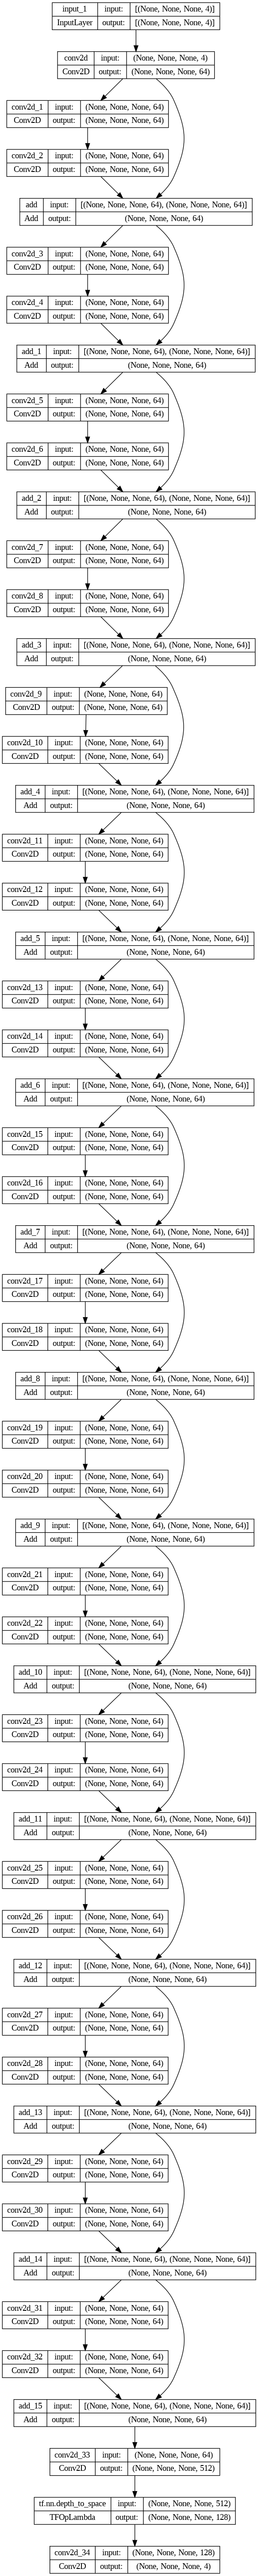

In [ ]:
#@title Model graph
keras.utils.plot_model(model, show_shapes=True)

#(Only for training step) Prepare the dataset for the created model

The input images to the model should be located in ```base_dir+'/halfsize/'```, and the output images should be in ```base_dir+'/real/'```. Both should share the same file names.

In [ ]:
#@title DataGenerator
import random

import numpy as np
from tensorflow import keras

class DataGenerator(tf.keras.utils.Sequence):
  def slice_images(self,xs,ys):
    ret_x, ret_y = [],[]
    x = 1-np.load(xs)/255
    y = 1-np.load(ys)/255
    if(mode == 'BW'):
      x = np.expand_dims(x[:,:,0],-1)
      y = np.expand_dims(y[:,:,0],-1)
    i = 0

    x1,y1 = random.randint(0,x.shape[0]-image_shape[0]-1), random.randint(0,x.shape[1]-image_shape[1]-1)
    x2,y2 = x1+image_shape[0],y1+image_shape[1]
    v = np.mean(y[x1:x2,y1:y2])
    if(True or v >= 0.02):
        ret_x.append(x[x1:x2,y1:y2:,])
        ret_y.append(y[x1*2:2*x2,y1*2:2*y2:,])
        i += 1
    return ret_x[0], ret_y[0]

  def __init__(self, dataset_images, oversampling = 1, shuffle=True, batch_size = 3, name = "", only_class = None, slice_once = False):

    self.slice_once = slice_once
    if(name == 'train'):
      self.dataset_images = ([v.replace("/%s/",'/halfsize/') for v in dataset_images*oversampling], [v.replace("/%s/",'/real/') for v in dataset_images*oversampling])
    else:
      self.dataset_images = ([v.replace("/%s/",'/halfsize/') for v in dataset_images], [v.replace("/%s/",'/real/') for v in dataset_images])

    if(name == 'train'):
      self.batch_size = batch_size
    else:
      self.batch_size = 1

    self.name = name
    self.data_aug = ['train']
    self.shuffle = shuffle
    self.on_epoch_end()


  def __len__(self):
      return self.steps_per_epoch

  def __getitem__(self, index):

    if(index >= np.floor(self.steps_per_epoch)):
      indexes = self.indexes[index*self.batch_size:]
    else:
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    list_IDs_temp = [(self.dataset_images[0][k],self.dataset_images[1][k]) for k in indexes]
    return self.__data_generation(list_IDs_temp)

  def data_augmentation(self,a,b):
    pass

  def on_epoch_end(self):
    if(self.batch_size == 1):
      self.steps_per_epoch = len(self.dataset_images[0])
    else:
      self.steps_per_epoch = (len(self.dataset_images[0]) // self.batch_size) +1 if(self.batch_size > 1) else 1
    self.indexes = np.arange(len(self.dataset_images[0]))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def _datagen(self, list_IDs_temp):
    if(self.name == 'train'):
      if(mode == 'BW'):
        X = np.empty((len(list_IDs_temp), image_shape[1], image_shape[0],1), dtype = np.float32)
        Y = np.empty((len(list_IDs_temp), 2*image_shape[1], 2*image_shape[0],1), dtype = np.float32)
      else:
        X = np.empty((len(list_IDs_temp), image_shape[1], image_shape[0],4), dtype = np.float32)
        Y = np.empty((len(list_IDs_temp), 2*image_shape[1], 2*image_shape[0],4), dtype = np.float32)

      for i,d in enumerate(list_IDs_temp):
        (x,y) = self.slice_images(*d)
        X[i,],Y[i,] = x,y
    else:
      X,Y = None,None

      for i,d in enumerate(list_IDs_temp):
        x,y = 1-np.load(d[0])/255, 1-np.load(d[1])/255
        if(X is None):
          if(mode == 'BW'):
            X = np.empty((len(list_IDs_temp), (x.shape[0]//2)*2 -1 , (x.shape[1]//2)*2 - 1,1), dtype = np.float32)
            Y = np.empty((len(list_IDs_temp), X.shape[1]*2, X.shape[2]*2, 1), dtype = np.float32)
          else:
            X = np.empty((len(list_IDs_temp), (x.shape[0]//2)*2 -1 , (x.shape[1]//2)*2 - 1,4), dtype = np.float32)
            Y = np.empty((len(list_IDs_temp), X.shape[1]*2, X.shape[2]*2, 4), dtype = np.float32)
        if(mode == 'BW'):
          x = np.expand_dims(x[:,:,0],-1)
          y = np.expand_dims(y[:,:,0],-1)
        X[i,] = x[:X.shape[1], : X.shape[2]:, :]
        Y[i,] = y[:Y.shape[1], : Y.shape[2]:, :]
    return X,Y

  def __data_generation(self, list_IDs_temp):
    return self._datagen(list_IDs_temp)
# ========================================
if(not load_pre_trained_model):
  all_datasets = []
  for fold in example_folds:
      all_datasets.append({})
      for key in fold:
          all_datasets[-1][key] = DataGenerator(fold[key], batch_size = batch_size, name=key)

#Main Routine

In [ ]:
#@title Export folder name
base_resultados = output_path+'/'
nome_pasta = '/'+model_name+'/'
export_folder_name = base_resultados+nome_pasta
try:
    os.mkdir(export_folder_name)
except FileExistsError:
    pass
export_folder_name

'/content///halftone_net/'

In [ ]:
#@title Build the model
optim = tf.keras.optimizers.Adam(
  learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[5000], values=[1e-4, 5e-5])
)

if(not load_pre_trained_model):
  import pickle
  for idx_data, datasets in enumerate(all_datasets):
    model = eval(model_name+model_by_name[model_name])
    model.compile(optimizer=optim, loss="mse", metrics=[tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanSquaredError()])
    history = model.fit(
        datasets['train'],
        validation_data=datasets['validation'],
        epochs=epochs,
        shuffle=True,
        verbose=1,
    )

    model.save_weights(export_folder_name+model_name+...+'_%d.h5'%idx_data)
    with open(export_folder_name+'dataset_%d.pck'%idx_data,'wb+') as f:
      pickle.dump(datasets,f)
else:
  model = eval(model_name+model_by_name[model_name])
  model.compile(optimizer=optim, loss="mse", metrics=[tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanSquaredError()])
  model.load_weights(base_resultados+weights_name)

/usr/local/lib/python3.10/dist-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



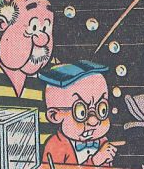
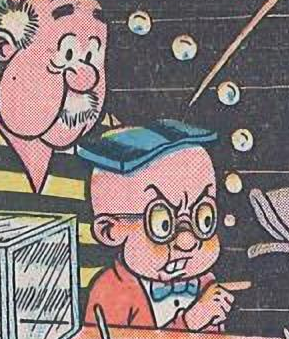
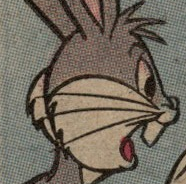
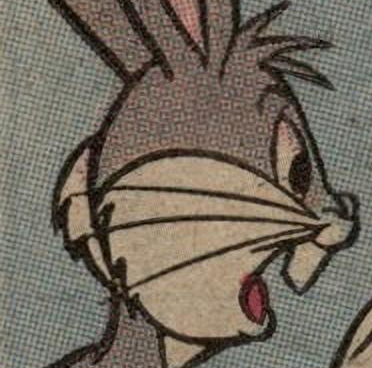
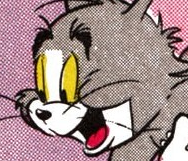
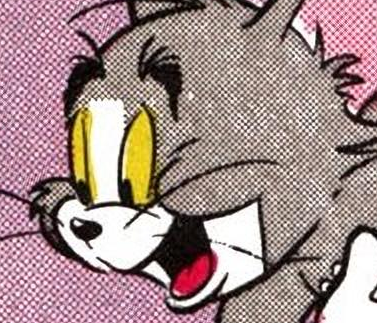


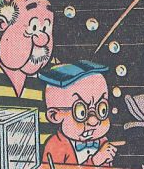
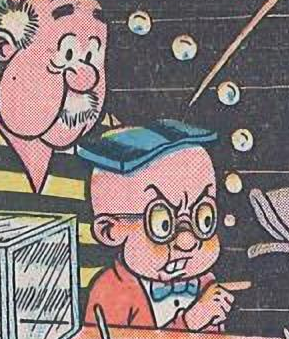
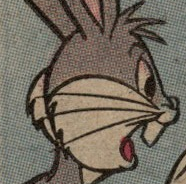
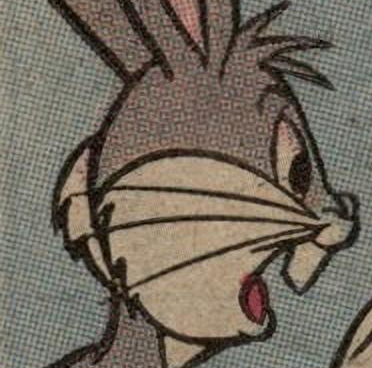
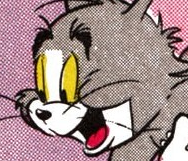
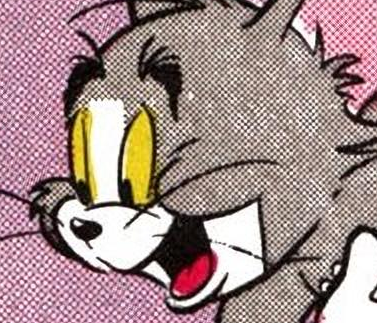

In [ ]:
#@title Samples image test
if('Comics' in target_model):
  images = {
      'feature_comics.jpg' : {'id':'https://i.imgur.com/Gh6IP6V.png',
                              'start':(698, 703),'box':(289, 339)},
      'bugs_bunny.jpg' : {'id': 'https://i.imgur.com/v5Cd5Op.png',
                          'start':(64, 1270),'box':(372, 368)},
      'tom_and_jerry.jpg' : {'id': 'https://i.imgur.com/wX3rFYq.png',
                            'start':(395, 1230),'box':(377, 323)},
  }
else:
    images = {
      'tiger.jpg' : {'id':'https://imgur.com/ChtP1oI.png',
                              'start':(134, 275),'box':(393, 340)},
      'rooster.jpg' : {'id': 'https://imgur.com/Nt6LN1l.png',
                          'start':(100, 420),'box':(327, 272)},
      'landscape.jpg' : {'id': 'https://imgur.com/HrzbrUg.png',
                            'start':(172, 416),'box':(190, 220)},
  }

images_list = []
for image_name in images:
  file_id = images[image_name]['id']
  !wget $file_id -O $image_name -q
  ori, img = do_upscale(image_name, show = False)
  s = images[image_name]['start']
  b = images[image_name]['box']
  ori = Image.fromarray(ori[s[1]//2:s[1]//2+b[1]//2, s[0]//2:s[0]//2+b[0]//2])
  img = Image.fromarray(img[s[1]:s[1]+b[1], s[0]:s[0]+b[0]])
  images_list.append(ori)
  images_list.append(img)

ipyplot.plot_class_representations(images_list, ['%d_original'%_ if _%2 == 0 else '%d_upscaled'%_ for _ in range(len(images)*2)], img_width = 600)

In [ ]:
import cv2
from PIL import Image
from IPython.display import display
#@title Upload a halftone image to enhance
from google.colab import files
while True:
  uploaded_files = list(files.upload().keys())
  for name in uploaded_files:
    do_upscale(name)